In [2]:
# magic command for automatic reload of python modules without needing to restart the notebook
%load_ext autoreload
%autoreload 2

In [16]:
# Supressing Warnings (Turn back on for code maintenance)
import warnings
warnings.filterwarnings('ignore')

In [17]:
import numpy as np
import scipy as sc
import tensorflow as tf
import tensorflow_probability as tfp
tfd=tfp.distributions
tfb=tfp.bijectors
from scipy import io
import time
import matplotlib.pyplot as plt
from sklearn import mixture
import joblib as jbl
import sys
import sklearn
import pandas as pd
import seaborn as sns
from pathlib import Path

In [18]:
# adding path to the parent folder of the GMCM library
sys.path.append(str(Path.cwd().parent))
from GMCM.mixture_models import GMCM, GMC
import GMCM.utils as utl

## Iris dataset (n_dims=4, n_samps=150)

Number of samples = 150, Number of dimensions = 4
Learning Marginals
Marginals learnt in 2.61 s.
@ Iter:0,                         Training error: -10.8,                         Validation error: nan,                         Time Elapsed: 6.6 s
@ Iter:1000,                         Training error: -13.2,                         Validation error: nan,                         Time Elapsed: 25.3 s
@ Iter:2000,                         Training error: -13.3,                         Validation error: nan,                         Time Elapsed: 43.6 s
@ Iter:3000,                         Training error: -13.8,                         Validation error: nan,                         Time Elapsed: 62.5 s
@ Iter:4000,                         Training error: -13.5,                         Validation error: nan,                         Time Elapsed: 81.4 s
@ Iter:5000,                         Training error: -13.4,                         Validation error: nan,                         Time Elapsed: 10

Text(0, 0.5, 'Log-likelihood')

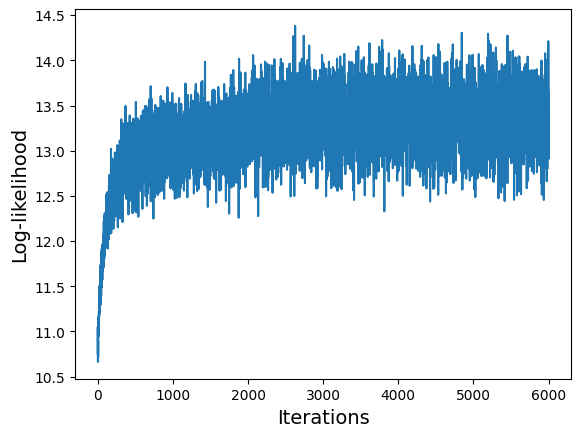

In [19]:
# Loading Iris data set from scikit learn data libraray
from sklearn.datasets import load_iris
data=load_iris().data.astype('float32')
nsamps,ndims = data.shape

# Defining a preprocessing bijective transform (eg, log transform in this case)
# orignal data x, define data transform y=log(x-min_val) (min val is conservatively obtained lower bound along each dimension)
# this "OPTIONAL" bijective transformation can be chained to the GMCM bijections (at the end). It improves the learning of marginals by mitigating heavy tails
min_val = (np.min(data)-3*np.std(data)).astype('float32')
log_transform = tfb.Chain([tfb.Shift(shift=min_val),tfb.Exp()])

# splitting the data into training, testing and validation sets
data_trn,data_vld,data_tst = utl.splitData(data)

nsamps,ndims = data.shape
print(f'Number of samples = {nsamps}, Number of dimensions = {ndims}')

# Initialing GMCM object
gmcm_iris=GMCM(ndims, data_transform=log_transform)

# Train GMCM (with 2 components)
nll_train,nll_vld,_=gmcm_iris.fit_dist_IFM(data_trn,
                                    n_comps=2,
                                    batch_size=10,
                                    max_iters=6001,
                                    regularize=True,
                                    init = 'random', #(init option: 'gmm' warm starts gmcm learning compared to 'random')
                                    print_interval=1000)

# Plot log-likelihood
plt.plot(-nll_train)
plt.xlabel('Iterations',fontsize=14)
plt.ylabel('Log-likelihood',fontsize=14)

In [20]:
# Learning GMM (with the same number of components) using scikit learn libraray
gmm_iris=utl.GMM_best_fit(data_trn,
                         min_ncomp=2,
                         max_ncomp=2,
                         max_iter=10000, 
                         print_info=True)

Fittng a GMM on samples with 2 components: BIC=415.348024


In [21]:
# Getting the marginals (of GMCM and GMM) along any two dimensions
dim1,dim2=0,1

# GMCM marginal
gmcm_iris_marg=gmcm_iris.get_marginal([dim1,dim2])

# GMM marginal
gmm_marg_mus=gmm_iris.means_[:,[dim1,dim2]].astype('float32')
gmm_marg_covs=tf.gather(tf.gather(gmm_iris.covariances_.astype('float32'),[dim1,dim2],axis=1),[dim1,dim2],axis=2)
gmm_marg_alphas=gmm_iris.weights_.astype('float32')
gmm_iris_marg=tfd.MixtureSameFamily(tfd.Categorical(probs=gmm_marg_alphas),
                               tfd.MultivariateNormalFullCovariance(loc=gmm_marg_mus,
                                                                    covariance_matrix=gmm_marg_covs))

#### Plotting 2-d density contours of the GMCM and GMM 

Text(0.5, 1.0, 'GMM density contours (Iris)')

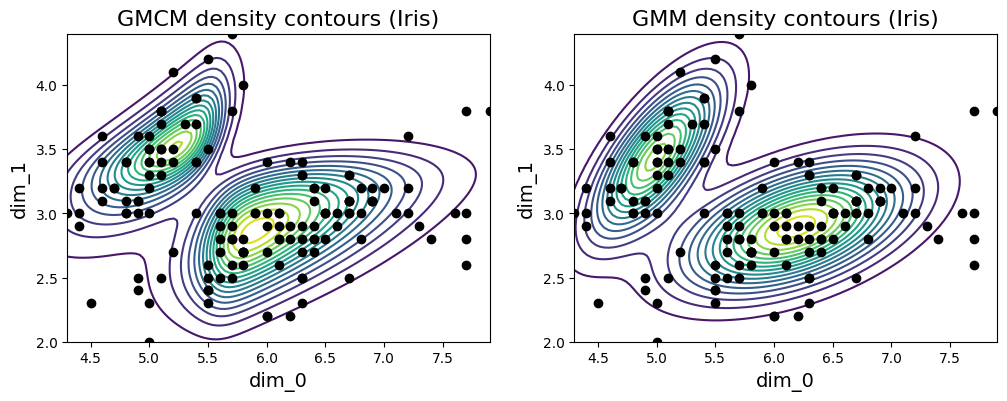

In [22]:
# Plotting the density contours along the two specified dimensions
fig,ax=plt.subplots(1,2,figsize=(12,4))

plt.sca(ax[0])
utl.plotDensityContours(data,gmcm_iris_marg.distribution.log_prob,dim1,dim2)
ax[0].set_title('GMCM density contours (Iris)',fontsize=16)

plt.sca(ax[1])
utl.plotDensityContours(data,gmm_iris_marg.log_prob,dim1,dim2)
ax[1].set_title('GMM density contours (Iris)',fontsize=16)


#### Predicting component labels and plotting them 

Text(0.5, 1.0, 'Scatter Plot with GMM predicted labels')

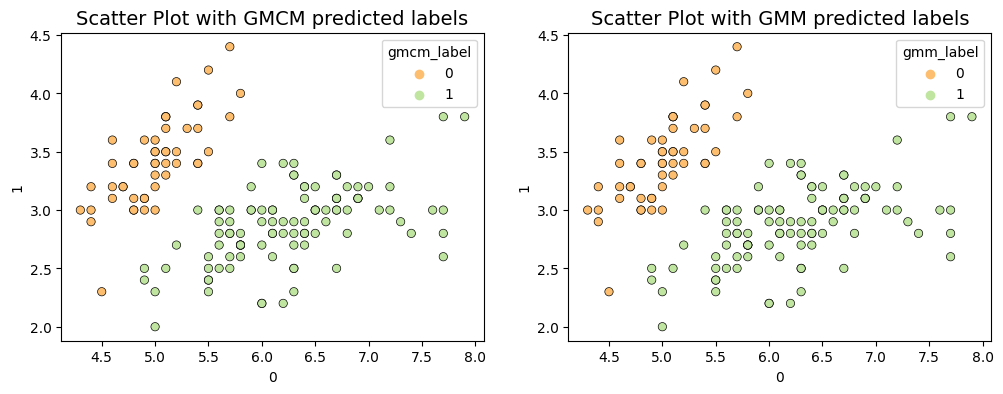

In [23]:
# Converting the data to a dataframe (to work with seaborn plotting library)
df = pd.DataFrame(data)
# adding a column with predicted labels
df['gmcm_label']=gmcm_iris.predict(data)
df['gmm_label']=gmm_iris.predict(data)

dim1,dim2=0,1

# Pairwise Scatter plotting with marker colors indicating component labels
fig,ax=plt.subplots(1,2,figsize=(12,4))

# plt.sca(ax[0])
sns.scatterplot(df,x=dim1,y=dim2,hue='gmcm_label',palette='Spectral',edgecolor='k',ax=ax[0])
ax[0].set_title('Scatter Plot with GMCM predicted labels',fontsize=14)

# plt.sca(ax[1])
sns.scatterplot(df,x=dim1,y=dim2,hue='gmm_label',palette='Spectral',edgecolor='k',ax=ax[1])
ax[1].set_title('Scatter Plot with GMM predicted labels',fontsize=14)

##  Wine dataset (n_dims=13, n_samps=178)

Number of samples = 178, Number of dimensions = 13
Learning Marginals
Marginals learnt in 7.99 s.
@ Iter:0,                         Training error: -33.5,                         Validation error: nan,                         Time Elapsed: 8.2 s
@ Iter:1000,                         Training error: -42.4,                         Validation error: nan,                         Time Elapsed: 35.2 s
@ Iter:2000,                         Training error: -41.8,                         Validation error: nan,                         Time Elapsed: 62.8 s
@ Iter:3000,                         Training error: -42.5,                         Validation error: nan,                         Time Elapsed: 89.3 s
@ Iter:4000,                         Training error: -41.0,                         Validation error: nan,                         Time Elapsed: 116.4 s
@ Iter:5000,                         Training error: -42.1,                         Validation error: nan,                         Time Elapsed: 

Text(0, 0.5, 'Log-likelihood')

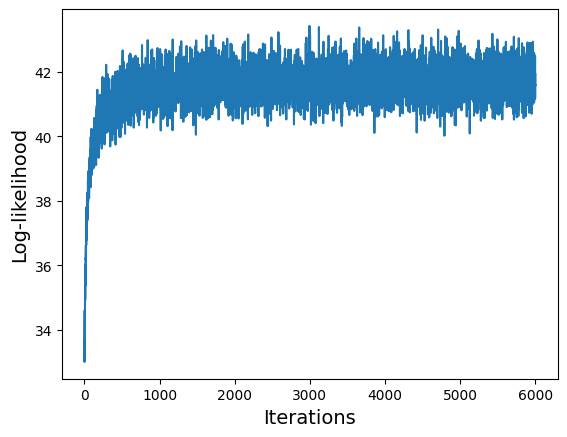

In [24]:
# Loading Iris data set from scikit learn data libraray
from sklearn.datasets import load_wine
data=load_wine().data.astype('float32')
nsamps,ndims = data.shape


# splitting the data into training, testing and validation sets
data_trn,data_vld,data_tst = utl.splitData(data)

nsamps,ndims = data.shape
print(f'Number of samples = {nsamps}, Number of dimensions = {ndims}')

# Initialing GMCM object
gmcm_wine=GMCM(ndims) # no data preprocessing this time

# Train GMCM (with 3 components)
nll_train,nll_vld,_=gmcm_wine.fit_dist_IFM(data_trn,
                                    n_comps=3,
                                    batch_size=20,
                                    max_iters=6001,
                                    regularize=True,
                                    init='random',
                                    print_interval=1000)

# Plot log-likelihood
plt.plot(-nll_train)
plt.xlabel('Iterations',fontsize=14)
plt.ylabel('Log-likelihood',fontsize=14)

In [25]:
# Learning GMM (with the same number of components) using scikit learn library
gmm_wine=utl.GMM_best_fit(data_trn,
                         min_ncomp=3,
                         max_ncomp=3,
                         max_iter=10000, 
                         print_info=True)

Fittng a GMM on samples with 3 components: BIC=5668.246771


In [26]:
# Getting the marginals (of GMCM and GMM) along any two dimensions
dim1,dim2=0,1

# GMCM marginal
gmcm_wine_marg=gmcm_wine.get_marginal([dim1,dim2])

# GMM marginal
gmm_marg_mus=gmm_wine.means_[:,[dim1,dim2]].astype('float32')
gmm_marg_covs=tf.gather(tf.gather(gmm_wine.covariances_.astype('float32'),[dim1,dim2],axis=1),[dim1,dim2],axis=2)
gmm_marg_alphas=gmm_wine.weights_.astype('float32')
gmm_wine_marg=tfd.MixtureSameFamily(tfd.Categorical(probs=gmm_marg_alphas),
                               tfd.MultivariateNormalFullCovariance(loc=gmm_marg_mus,
                                                                    covariance_matrix=gmm_marg_covs))

#### Plotting 2-d density contours of the GMCM and GMM 

Text(0.5, 1.0, 'GMM density contours (Wine)')

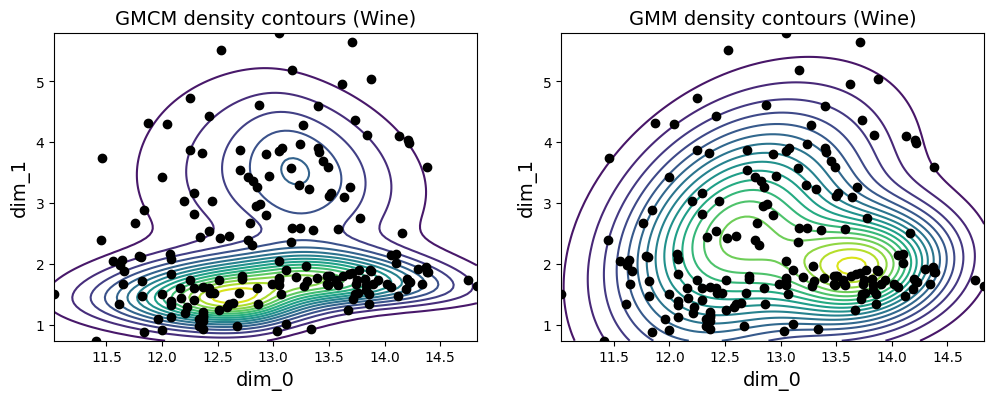

In [27]:
# Plotting the density contours along the two specified dimensions
fig,ax=plt.subplots(1,2,figsize=(12,4))

plt.sca(ax[0])
utl.plotDensityContours(data,gmcm_wine_marg.distribution.log_prob,dim1,dim2)
ax[0].set_title('GMCM density contours (Wine)',fontsize=14)

plt.sca(ax[1])
utl.plotDensityContours(data,gmm_wine_marg.log_prob,dim1,dim2)
ax[1].set_title('GMM density contours (Wine)',fontsize=14)


#### Predicting component labels and plotting them 

Text(0.5, 1.0, 'Scatter Plot with GMM predicted labels')

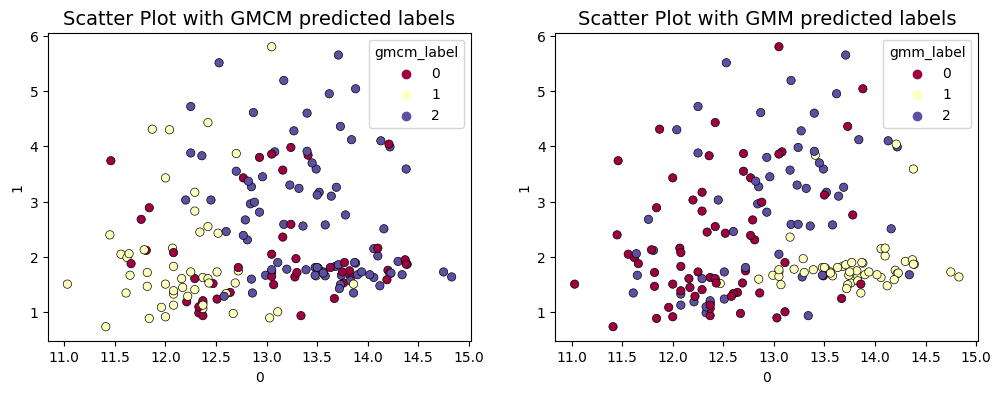

In [34]:
# Converting the data to a dataframe (to work with seaborn plotting library)
df = pd.DataFrame(data)
# adding a column with predicted labels
df['gmcm_label']=gmcm_wine.predict(data)
df['gmm_label']=gmm_wine.predict(data)

dim1,dim2=0,1

# Pairwise Scatter plotting with marker colors indicating component labels
fig,ax=plt.subplots(1,2,figsize=(12,4))

# plt.sca(ax[0])
sns.scatterplot(df,x=dim1,y=dim2,hue='gmcm_label',palette='Spectral',edgecolor='k',ax=ax[0])
ax[0].set_title('Scatter Plot with GMCM predicted labels',fontsize=14)

# plt.sca(ax[1])
sns.scatterplot(df,x=dim1,y=dim2,hue='gmm_label',palette='Spectral',edgecolor='k',ax=ax[1])
ax[1].set_title('Scatter Plot with GMM predicted labels',fontsize=14)